In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install -q -U tfds-nightly

    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.
     |████████████████████████████████| 4.1 MB 11.1 MB/s 


In [ ]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt


In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]
  
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = fcn_model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model_fcn.predict(sample_image[tf.newaxis, ...]))])
    
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(test_dataset,1)
        print ('\n에포크 이후 예측 예시 {}\n'.format(epoch+1))

In [ ]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (224, 224))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (224, 224))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (224, 224))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (224, 224))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import Input

inputs = Input(shape=(224, 224, 3))
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(inputs)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
f1 = x
    
# Block 2
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
f2 = x

# Block 3
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
pool3 = x

# Block 4
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)## (None, 14, 14, 512) 

# Block 5
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(pool4)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
pool5 = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)## (None, 7, 7, 512)
    
o = Conv2D(4096, (7, 7), activation='relu', padding='same', name="conv6")(pool5)
conv7 = Conv2D(3, (1, 1), activation='relu', padding='same', name="conv7")(o)

conv7_4 = UpSampling2D(size=(2, 2), interpolation='bilinear')(conv7)
conv7_4 = Conv2D(3, (3, 3), (1, 1), activation='relu', padding='same')(conv7_4)

pool411 = Conv2D(3, (1, 1), activation='relu', padding='same', name="pool4_11")(pool4)
pool411 = Add(name="add")([pool411, conv7_4])
pool411_2 = UpSampling2D(size=(2, 2), interpolation='bilinear')(pool411)
pool411_2 = Conv2D(3, (3, 3), (1, 1), activation='relu', padding='same')(pool411_2)
    
pool311 = Conv2D(3, (1, 1), activation='relu' , padding='same', name="pool3_11")(pool3)
o = Add(name="add2")([pool411_2, pool311])
o = UpSampling2D(size=(8, 8), interpolation='bilinear')(o)
o = Conv2D(3, (3, 3), (1, 1), activation='relu', padding='same')(o)

fcn_model = tf.keras.Model(inputs, o)

fcn_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

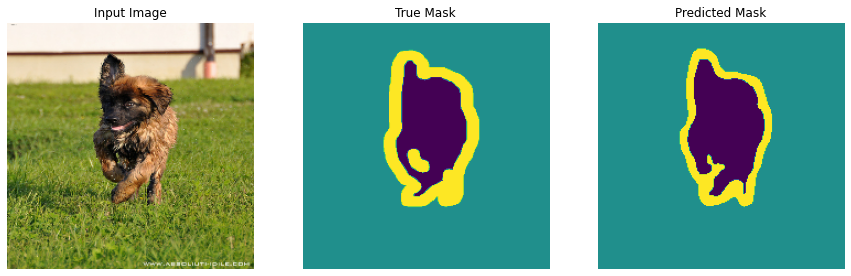


에포크 이후 예측 예시 72

57/57 [==============================] - 165s 3s/step - loss: 0.1198 - val_loss: 0.5213
Epoch 73/100
17/57 [=======>......................] - ETA: 1:45 - loss: 0.1177

KeyboardInterrupt: ignored

In [ ]:
from tensorflow import keras
# model_fcn.compile(optimizer=keras.optimizers.SGD(momentum=0.9,nesterov=True),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
fcn_model.compile(optimizer=keras.optimizers.Adam(),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

EPOCHS = 100
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = fcn_model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])